In [73]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

In [74]:
mask_path = "/home/diogommiranda/tese/masks/ROI_MASK.nii"
img = nib.load(mask_path)
volume = img.get_fdata(dtype=np.float32)
current_min = np.min(volume)
current_max = np.max(volume)
print(f"Calculated Min: {current_min}, Max: {current_max}")
volume = np.transpose(volume, (2, 1, 0)) # (D, H, W)
volume = np.expand_dims(volume, axis=0) # Add channel dimension
volume = np.expand_dims(volume, axis=0) # Add batch dimension
volume = torch.from_numpy(volume)
print(f"Shape after transpose: {volume.shape}")

Calculated Min: 0.0, Max: 1.0
Shape after transpose: torch.Size([1, 1, 91, 109, 91])


In [75]:
roi_scores = F.interpolate(
    input = volume,
    mode = 'area',
    size = (6, 7, 6)
)
print(roi_scores.shape)
roi_scores = roi_scores.squeeze(0).squeeze(0)  # Remove batch and channel dimensions
print(roi_scores.shape)

torch.Size([1, 1, 6, 7, 6])
torch.Size([6, 7, 6])


In [76]:
roi_min = torch.min(roi_scores)
roi_max = torch.max(roi_scores)
print(f"ROI Min: {roi_min.item()}, ROI Max: {roi_max.item()}")

ROI Min: 0.0, ROI Max: 0.572021484375


In [77]:
token_roi_scores = roi_scores.flatten()
print(f"Token ROI Scores Shape: {token_roi_scores.shape}")

Token ROI Scores Shape: torch.Size([252])


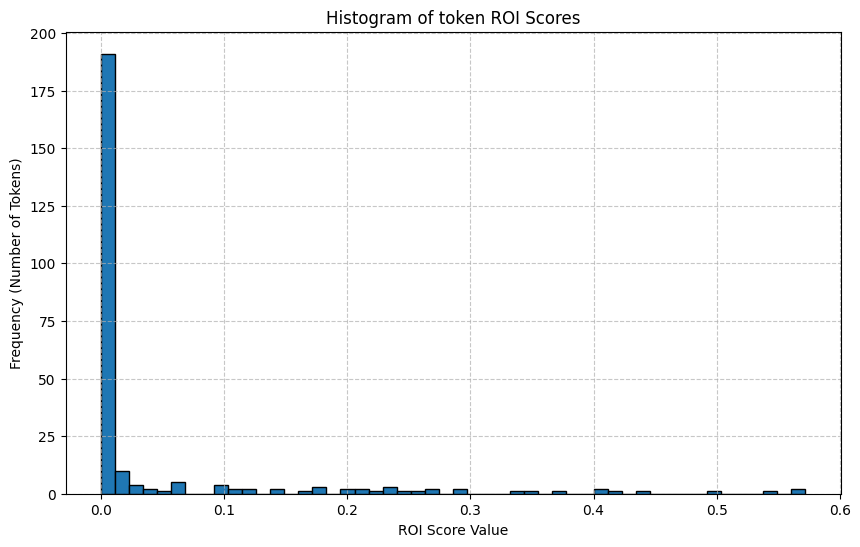

In [147]:
# 1. Histogram of Original Interpolated (but not yet softmaxed) Token ROI Scores
plt.figure(figsize=(10, 6))
plt.hist(token_roi_scores.cpu().numpy(), bins=50, edgecolor='black')
plt.title("Histogram of token ROI Scores")
plt.xlabel("ROI Score Value")
plt.ylabel("Frequency (Number of Tokens)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Note: 
- Only 81 tokens have non-zero scores
- Only 63 tokens have score greater than 0.01
- Only 45 tokens have score greater than 0.05
- Only 37 tokens have score greater than 0.1
- Only 11 tokens have score greater than 0.3

In [142]:
boolean = (token_roi_scores > 0.1)
len(boolean[boolean == True]) # Number of tokens with score > 0.025
print(f"Number of tokens with score > 0.1: {len(boolean[boolean == True])}/{len(boolean)}")

Number of tokens with score > 0.1: 37/252


In [140]:
# get the index of the token with the greatest score
max_score = torch.max(token_roi_scores)
indices = torch.where(token_roi_scores==max_score)[0]
print(f"Index of tokens with greatest score {max_score}: {indices.tolist()}")

Index of tokens with greatest score 0.572021484375: [97]


In [115]:
boolean[97]

tensor(True)


Softmax (T=1) Min: 0.003775653662160039, Max: 0.006689873989671469


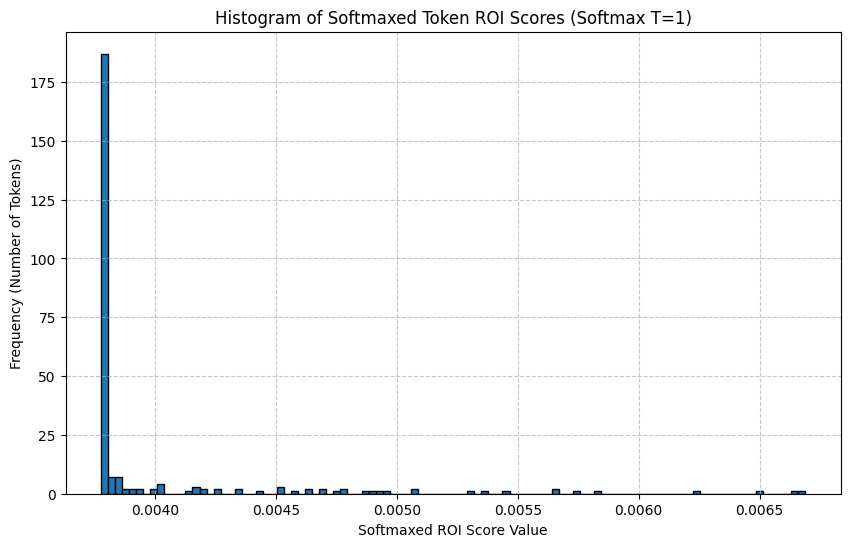

In [145]:
token_roi_scores_softmax = F.softmax(token_roi_scores, dim=0)
softmax_min_temp = torch.min(token_roi_scores_softmax)
softmax_max_temp = torch.max(token_roi_scores_softmax)
print(f"\nSoftmax (T={1}) Min: {softmax_min_temp.item()}, Max: {softmax_max_temp.item()}")

plt.figure(figsize=(10, 6))
plt.hist(token_roi_scores_softmax.cpu().numpy(), bins=100, edgecolor='black')
plt.title("Histogram of Softmaxed Token ROI Scores (Softmax T=1)")
plt.xlabel("Softmaxed ROI Score Value")
plt.ylabel("Frequency (Number of Tokens)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Softmax (T=0.5) Min: 0.0035357263404875994, Max: 0.011100184172391891


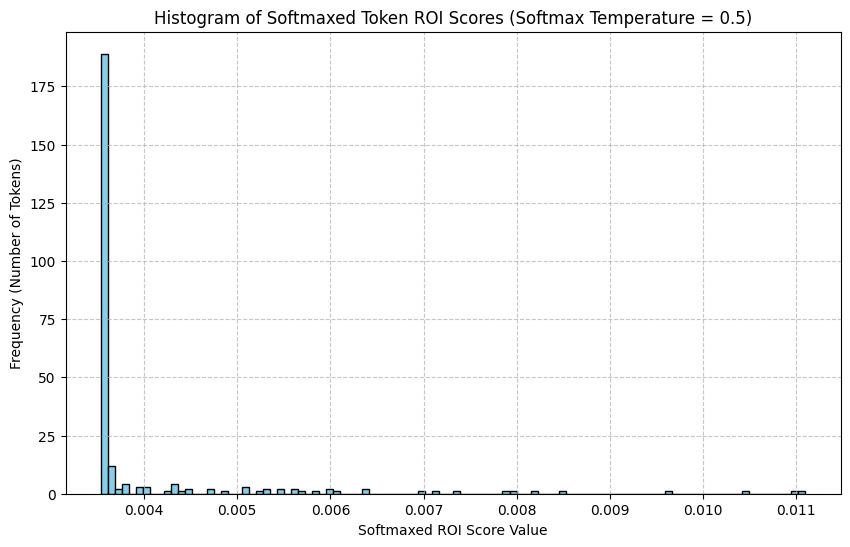


Softmax (T=0.1) Min: 0.0005645053461194038, Max: 0.1721574366092682


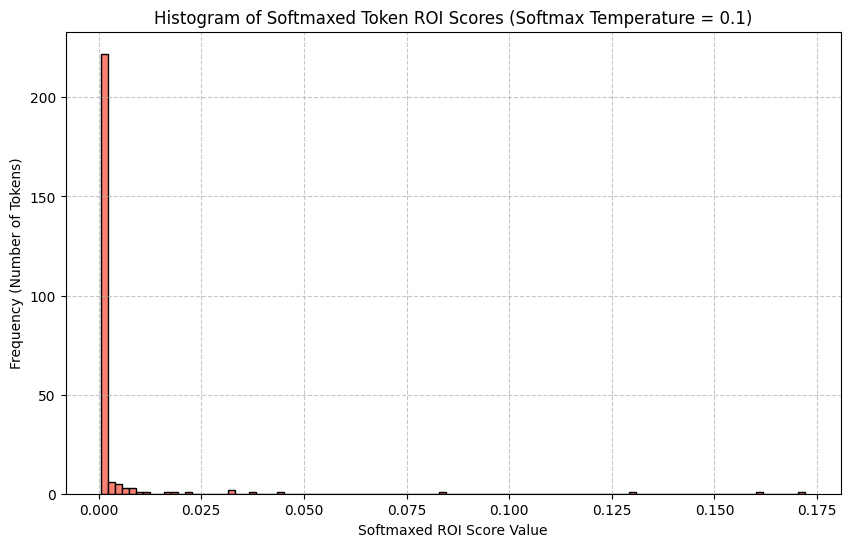


Softmax (T=0.05) Min: 3.67123197975161e-06, Max: 0.34145015478134155


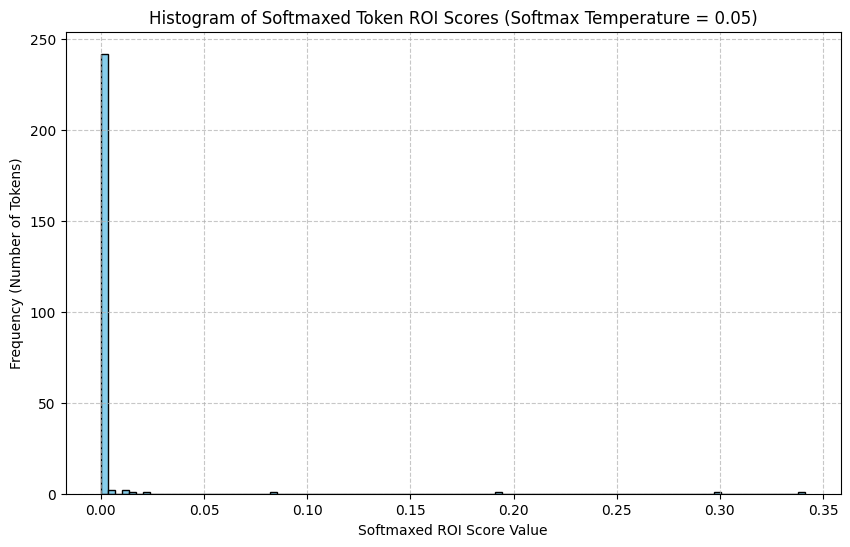

In [146]:
temperatures_to_try = [0.5, 0.1, 0.05]

for T in temperatures_to_try:
    token_roi_scores_softmax = F.softmax(token_roi_scores / T, dim=0)
    softmax_min_temp = torch.min(token_roi_scores_softmax)
    softmax_max_temp = torch.max(token_roi_scores_softmax)
    print(f"\nSoftmax (T={T}) Min: {softmax_min_temp.item()}, Max: {softmax_max_temp.item()}")

    plt.figure(figsize=(10, 6))
    plt.hist(token_roi_scores_softmax.cpu().numpy(), bins=100, facecolor='skyblue' if T !=0.1 else 'salmon', edgecolor='black')
    plt.title(f"Histogram of Softmaxed Token ROI Scores (Softmax Temperature = {T})")
    plt.xlabel("Softmaxed ROI Score Value")
    plt.ylabel("Frequency (Number of Tokens)")
    plt.grid(True, linestyle='--', alpha=0.7)
    # You might want to adjust x-axis limits for very peaky distributions
    # plt.xlim([0, max(0.01, softmax_max_temp.item() * 1.1)]) # Example dynamic xlim
    plt.show()